In [1]:
import numpy as np
import pandas as pd
from math import *
import time
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
import gridrender 
from gridworld import GridWorld1
import gridrender as gui
import utils

# Dynamic Programming
## Question 1

The MDP model is defined by the following :

In [2]:
# Set of states
X = [0, 1, 2]

# Set of actions
A = [0, 1, 2]

# Transition probabilities
p = np.zeros((3, 3, 3))
p[0, 0] = [0.55, 0.45, 0.]
p[1, 0] = [0, 1, 0]
p[2, 0] = [0, 1, 0]
p[0, 1] = [0.3, 0.7, 0]
p[1, 1] = [0, 0.4, 0.6]
p[2, 1] = [0, 0.6, 0.4]
p[0, 2] = [1, 0, 0]
p[1, 2] = [0, 1, 0]
p[2, 2] = [0, 0, 1]


# Reinforcement
r = np.zeros((3, 3))
r[0, 0] = 0
r[1, 0] = 0
r[2, 0] = 0
r[0, 1] = 0
r[1, 1] = 0
r[2, 1] = 1
r[0, 2] = 5/100
r[1, 2] = 0
r[2, 2] = 9/10

In this simple MDP the optimal policy $\pi^*$ is :

- In $s_0$ : do $a_1$
- In $s_1$ : do $a_1$
- In $s_2$ : do $a_2$

In [3]:
# Optimal policy :
pi_star = np.zeros(len(X), dtype=int)
pi_star[0] = 1
pi_star[1] = 1
pi_star[2] = 2

## Question 2

In [4]:
gamma = 0.95

### Policy Evaluation to compute $v^*$

In [5]:
# Optimal value function with policy pi*
p_pi = np.array([p[i, pi_star[i]] for i in X])
r_pi = np.array([r[i, pi_star[i]] for i in X])
v_star = np.linalg.inv(np.eye(3) - gamma*p_pi).dot(r_pi)

### Value iteration

In [6]:
# Bellman operator 
# Point-wise
def bellman_op(v, x, X, a, p, r, gamma = 0.95):
    return r[x, a] + gamma * sum([p[x,a,y]*v[y] for y in X])
def T_pw(v, x, X, A, p, r, gamma = 0.95):
    return max([bellman_op(v, x, X, a, p, r, gamma) for a in A])
# Vector
def T(v, X, A, p, r, gamma = 0.95):
    fun = lambda x: T_pw(v, x, X, A, p, r, gamma = 0.95)
    return np.array(list(map(fun, X)))

In [7]:
# Value Iteration 
# Parameters
n_iter = 0
eta = 0.01
gamma = 0.95
eps = (1-gamma)*eta/(2*gamma)

# Initialization
v0 = [0, 0, 0]

norm_inf_tab = []
prev_v = v0
v = T(v0, X, A, p, r)
norm_inf_tab.append(np.linalg.norm(v_star-v, ord=inf))

# Main loop
while np.linalg.norm(v_star-v, ord=inf) > eps:
    prev_v = v
    v = T(v, X, A, p, r)
    
    norm_inf_tab.append(np.linalg.norm(v_star-v, ord=inf))
    n_iter += 1

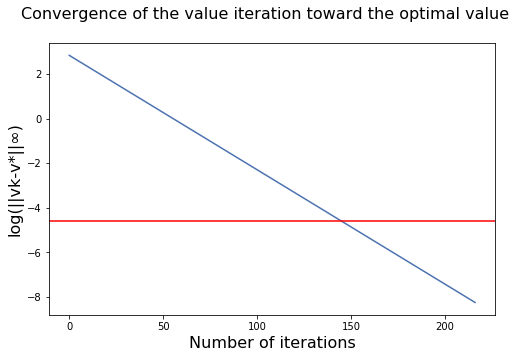

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(list(map(log,norm_inf_tab)), label = '||vk-v*||∞')
plt.axhline(log(eta), c='r', label = 'Precisions criterion')
plt.suptitle('Convergence of the value iteration toward the optimal value', size = 16)
plt.xlabel('Number of iterations', size = 16)
plt.ylabel('log(||vk-v*||∞)', size = 16)
plt.show()

The graph above represent the evolution of Value Iteration algorithm compared to the value function of the optimal policy $v^*$. The redline represents a 0.01 difference. We see that we can achieve an arbitrary precision $\eta$ by stopping when $||v^k - v^{k-1}||_\infty < \epsilon$ for $\epsilon = \frac{1-\gamma}{2\gamma}\eta$.

## Question 3

## Policy Iteration

In [9]:
# Optimal value function with policy pi*
def get_value_from_policy(pi, X, r, gamma = 0.95):
    '''Returns the value function for a given policy pi.'''
    p_pi = np.array([p[x, pi[x]] for x in X])
    r_pi = np.array([r[x, pi[x]] for x in X])
    return np.linalg.inv(np.eye(len(X)) - gamma*p_pi).dot(r_pi)

def policy_iteration_state(v, x, X, A, p, r, gamma = 0.95):
    '''Compute a step of the policy interation algorithm for a given state x.'''
    return A[np.argmax([bellman_op(v, x, X, a, p, r, gamma) for a in A])]

def policy_iteration(v, X, A, p, r, gamma = 0.95):
    '''Compute a step of the policy interation algorithm for the set of states X'''
    fun = lambda x: policy_iteration_state(v, x, X, A, p, r, gamma)
    return np.array(list(map(fun, X)))

In [10]:
# Policy iteration algorithm
# Initial policy
pi = [0, 0, 0]
iterations = 0
while True:
    # Until convergence, repeat:
    prev_pi = pi
    # Policy evaluation
    v = get_value_from_policy(pi, X, r)
    # Policy improvement
    pi = policy_iteration(v, X, A, p, r)
    if (prev_pi == pi).all():
        break    
    iterations += 1
print("Converged in {} iterations".format(iterations))
print("Final policy : ", pi)

Converged in 3 iterations
Final policy :  [1 1 2]


## Comments

- PI converges in only a few iterations, but requires the inversion of a N sized matrix at each step: complexity $O(n^3)$ with the Gaussian Elimination algorithm, $O(n^{2.373})$ with Optimized CW-like algorithms.
- In VI each iteration has a complexity $O(An^2)$ which is much smaller than for PI, however the algorithm will require more iterations and can only approach the optimal value function asymptoticaly.

# Reinforcement Learning

In [11]:
env = GridWorld1

## Question 4

In [12]:
# Question 4
# Fixed policy : 'right when available, up otherwise'
det_pol = [0 if (0 in s) else 3 for s in env.state_actions]
print("Deterministic policy: ", det_pol)

Deterministic policy:  [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3]


In [13]:
def trajectory_simulation(env, state, policy, Tmax = 200):
    '''Simulates a trajectory until an absorbing state is reached 
    or Tmax steps have been taken. Return the list of steps and rewards'''
    s = state
    states = []
    rewards = []
    t = 0
    while t < Tmax:
        a = policy[s]
        next_state, r, absorb = env.step(s, a)
        rewards.append(r)
        states.append(next_state)
        s = next_state
        if absorb:
            break
        t += 1
    return states, rewards

def get_discounted_rewards(rewards, gamma = 0.95, T_max = None):
    '''Computes the discouted rewards for a list of rewards and a discount rate gamma.'''
    if (T_max is not None):
        rewards = rewards[:T_max]
    gammas = np.array([gamma**t for t in range(len(rewards))])
    return gammas.dot(np.array(rewards))

## Estimation of $\mu$

In [14]:
def estimate_density(env, sample_size = 100):
    '''Estimates the starting state distribution of an environnement
    with a given sample size.'''
    i = 0
    mu = np.zeros(env.n_states)
    while i < sample_size:
        s = env.reset()
        mu[s] += 1
        i+=1
    mu = mu/np.sum(mu)
    return mu

In [15]:
mu = estimate_density(env,sample_size=1e4)
print("Estimated starting state density with 10^4 iterations : \n", mu)

Estimated starting state density with 10^4 iterations : 
 [0.1422 0.089  0.0899 0.0408 0.0901 0.0914 0.0901 0.0926 0.087  0.0979
 0.089 ]


In [24]:
def value_estimator(state, N, policy):
    '''Estimates the value of a state based on a given policy 
    using a Monte-Carlo simulation of size N'''
    value = []
    for i in range(N):
        # Simulate a trajectory
        states, rewards = trajectory_simulation(env, state, policy)
        # Compute the discounted rewards
        disc_rewards = get_discounted_rewards(rewards)
        value.append(disc_rewards)
    return np.mean(np.array(value))
            
def value2vec(n, policy):
    '''Returns a Monte-Carlo estimation of size n of the value function given a policy'''
    n_s = n//env.n_states
    return np.array([value_estimator(s, n_s, policy) for s in range(env.n_states)])

def compute_J(mu, value_estimator):
    '''Computes the total value function weighted by the starting state distribution mu'''
    return np.array(mu).dot(np.array(value_estimator))

In [17]:
v_pi = [0.87691855, 0.92820033, 0.98817903, 0.00000000, 0.67106071, -0.99447514, 
        0.00000000, -0.82847001, -0.87691855, -0.93358351, -0.99447514]
J_pi = compute_J(mu, v_pi)

n_tab=np.linspace(20, 1e4, 50)
delta_J = []
for n in n_tab:
    J_n = compute_J(mu, value2vec(n=int(n), policy=det_pol))
    delta_J.append(abs(J_n - J_pi))

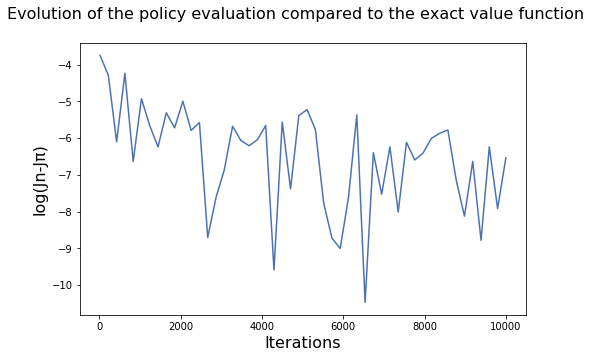

In [18]:
plt.figure(figsize=(8,5))
plt.suptitle('Evolution of the policy evaluation compared to the exact value function',
             size = 16)
plt.plot(n_tab, list(map(log,delta_J)))
plt.xlabel('Iterations', size= 16)
plt.ylabel('log(Jn-Jπ)', size=16)
plt.show()

# Question 5

$\bullet$ The following stepsize satisfies the Robbins-Monro conditions: $\forall x \in X, \forall a \in A, \alpha_i(x, a) = \frac{1}{i}$.

$\bullet$ Policy : exploitation with probability $1-\epsilon$, exploration with probability $\epsilon$. For this relatively simple environnement we can set $\epsilon = 0.3$ for example.

In [19]:
# Stepsize
alpha = lambda i, x, a : 1/i

# Random exploration policy
exploration_policy = lambda env, s: np.random.choice(env.state_actions[s])

# epsilon-greedy exploration
def e_greedy_exploration(env, s, Q, eps):
    p = np.random.binomial(1, eps)
    if p == 1:
        return exploration_policy(env, s)
    else:
        return np.argmax(Q[s,:])

def init_Q(env):
    '''Initialize randomly the matrix Q and set to -inf 
    the value of non-admissible actions'''
    Q = np.random.uniform(size=(env.n_states, len(env.action_names)))
    Q = [[Q[s,a] if (a in env.state_actions[s]) else -np.Infinity
                   for a in range(len(env.action_names))] 
                   for s in range(env.n_states)]
    return np.array(Q)
    
def Q_learning(env, episodes, Tmax, eps):
    '''Perform the Q-Learning with an epsilon-greedy exploration policy'''
    Q = init_Q(env)
    N = np.ones((env.n_states, len(env.action_names)))
    Q_epi = []
    rewards = []
    episode = 0
    while episode < episodes:
        Q, N, reward = Q_learning_episode(env, Q, N, Tmax, eps)
        Q_epi.append(Q)
        rewards.append(reward)
        episode += 1
    return Q_epi, rewards
    
def Q_learning_episode(env, Q, N, Tmax, eps):
    '''Perform one episode of the Q-Learning algorithm. 
    Return matrices Q, N and the cumulative reward.'''
    t = 0
    s = env.reset()
    Q_p = Q.copy()
    cumulative_reward = 0
    while t < Tmax:
        # Pick an action according to the exploration policy
        a = e_greedy_exploration(env, s, Q_p, eps)
        # Take a step 
        next_state, r, absorb = env.step(s, a)
        # Stepsize
        alp= alpha(N[s,a], s, a)
        # Update Q
        Q_p[s,a] = (1-alp) * Q_p[s,a] + alp * (r + gamma * max(Q_p[next_state,:]))
        N[s,a] += 1
        cumulative_reward += r
        # Reset if an absorbing state is reached
        if absorb:
            s = env.reset()
        else:
            s = next_state  
        t+=1
    return Q_p, N, cumulative_reward

def Q2policy(Q):
    return np.argmax(Q, axis = 1)

In [20]:
# v*
v_opt = np.array([0.87691855, 0.92820033, 0.98817903, 0.00000000, 0.82369294, 0.92820033, 
                  0.00000000, 0.77818504, 0.82369294, 0.87691855, 0.82847001])
# Q Learning algorithm
n_episodes = 30
Tmax = 50
N_value = int(1e4)
eps = 0.3
Q_epi, r = Q_learning(env, n_episodes, Tmax, eps)
delta_v = []
for Q in Q_epi:
    pol = Q2policy(Q)
    value = value2vec(N_value, pol)
    delta_v.append(np.linalg.norm(value-v_opt, ord = inf))

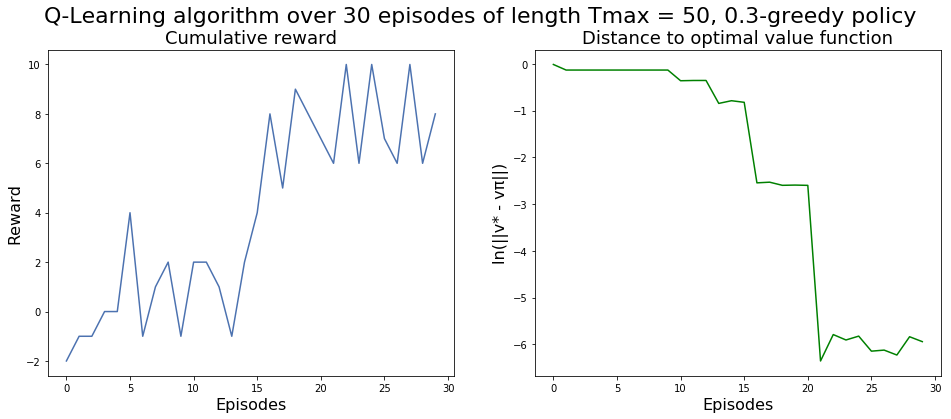

In [21]:
plt.figure(figsize=(16, 6))
plt.suptitle('Q-Learning algorithm over {} episodes of length Tmax = {}, {}-greedy policy'.
             format(n_episodes, Tmax, eps), size = 22)
plt.subplot(1, 2, 1)
plt.title('Cumulative reward', size = 18)
plt.plot(r)
plt.xlabel('Episodes', size= 16)
plt.ylabel('Reward', size = 16)
plt.subplot(1, 2, 2)
plt.plot(list(map(log, delta_v)), c = 'g')
plt.title('Distance to optimal value function', size = 18)
plt.xlabel('Episodes', size = 16)
plt.ylabel('ln(||v* - vπ||)', size= 16)
plt.show()

In [23]:
print("Average performance over all states over last 5 episodes :", np.mean(delta_v[-5:]))

Average performance over all states over last 5 episodes : 0.0023749258180725706


- We see that the cumulative reward increases with the episodes, but stays volatile because of the exploration policy.
- The performance over all states converges in a few episodes, but then oscillates at around $0.002-0.003$.

# Question 6

The initial distribution only impacts how often certain states will be visited compared to others. However **it will not affect the optimal policy**: for example the Q-Learning algorithm - which approaches the optimal policy asymptotically - makes the assumption that all state-action pairs are visited infinitely often; in this case having certain states visited more often than others do not have any impact on the convergence of the algorithm.